# SI 370 - Homework #4: Machine Learning 1

In this homework exercise you will apply the machine learning techniques we've covered so far: linear regression,
machine learning pipelines, agglomerative clustering, k-means clustering, and t-SNE.

We will be using [graduate admissions data](https://www.kaggle.com/mohansacharya/graduate-admissions).

This is a fairly involved homework assignment and we *strongly* urge you to not leave this to the last minute.
We suggest that you try to work on this assignment over several days.



In [420]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_squared_error
from sklearn.manifold import TSNE

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [422]:
admit = pd.read_csv('https://raw.githubusercontent.com/umsi-data-science/data/main/Admission_Predict.csv',
                    index_col="Serial No.")

In [423]:
admit.shape

(400, 8)

In [424]:
admit.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
Serial No.,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92
2,324,107,4,4.0,4.5,8.87,1,0.76
3,316,104,3,3.0,3.5,8.00,1,0.72
4,322,110,3,3.5,2.5,8.67,1,0.80
5,314,103,2,2.0,3.0,8.21,0,0.65


## Task 1 (2 points):
Perform basic exploratory data analyses on the variables in this dataframe.  Your work should include both
numerical **and** graphical overviews of the data.  The `multiplePlots` code might be helpful here.

In [425]:
admit.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

In [426]:
admit.dropna(how='any', inplace=True)

In [427]:
admit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          400 non-null    int64  
 1   TOEFL Score        400 non-null    int64  
 2   University Rating  400 non-null    int64  
 3   SOP                400 non-null    float64
 4   LOR                400 non-null    float64
 5   CGPA               400 non-null    float64
 6   Research           400 non-null    int64  
 7   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 28.1 KB


In [428]:
admit.describe()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.807500,107.410000,3.087500,3.400000,3.452500,8.598925,0.547500,0.724350
std,11.473646,6.069514,1.143728,1.006869,0.898478,0.596317,0.498362,0.142609
min,290.000000,92.000000,1.000000,1.000000,1.000000,6.800000,0.000000,0.340000
25%,308.000000,103.000000,2.000000,2.500000,3.000000,8.170000,0.000000,0.640000
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.610000,1.000000,0.730000
75%,325.000000,112.000000,4.000000,4.000000,4.000000,9.062500,1.000000,0.830000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000,1.000000,0.970000


In [429]:
def multiplePlots(series):

    fig, axs = plt.subplots(2, 2)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

    # Histogram
    sns.distplot(series, ax=axs[0, 0])

    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(current, lag, fit_reg=False, ax=axs[0, 1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")

    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(xr, qntls, ax=axs[1, 0])

    # Run sequence
    ax = sns.regplot(np.arange(len(series)), series, ax=axs[1, 1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")

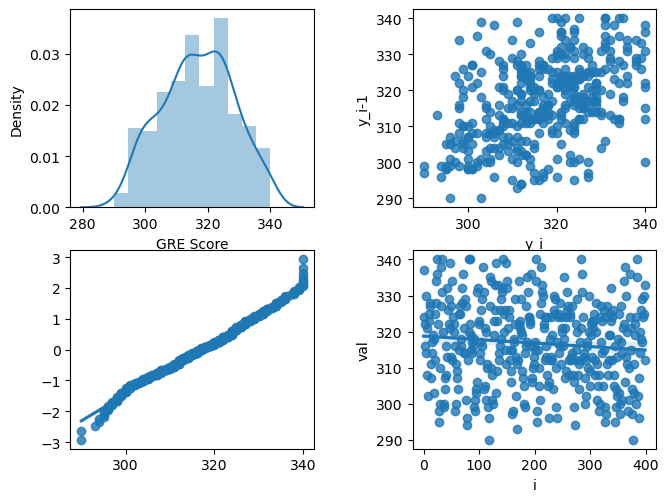

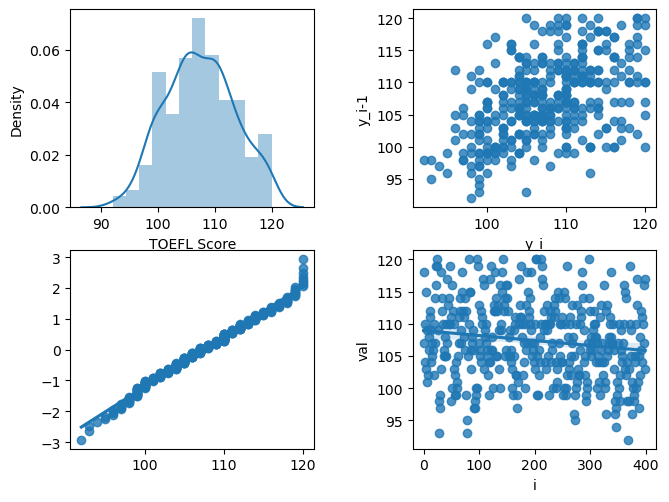

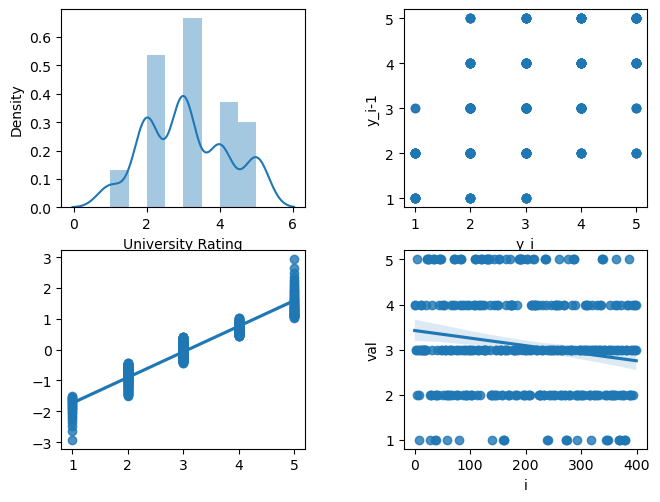

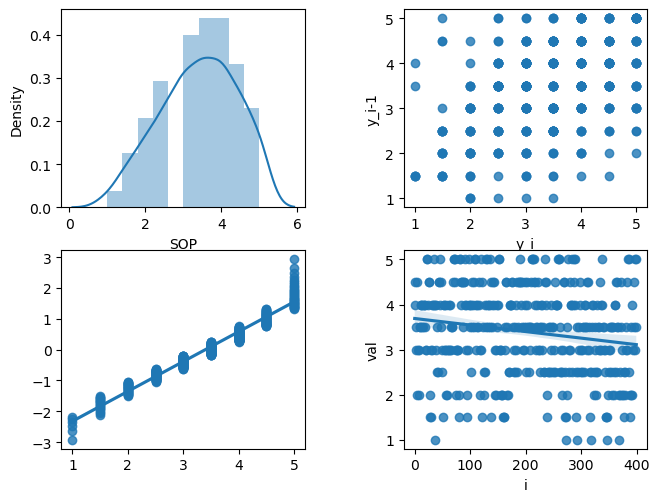

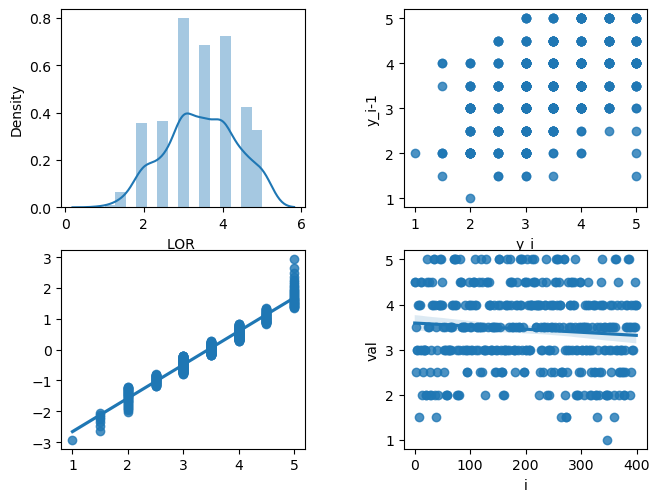

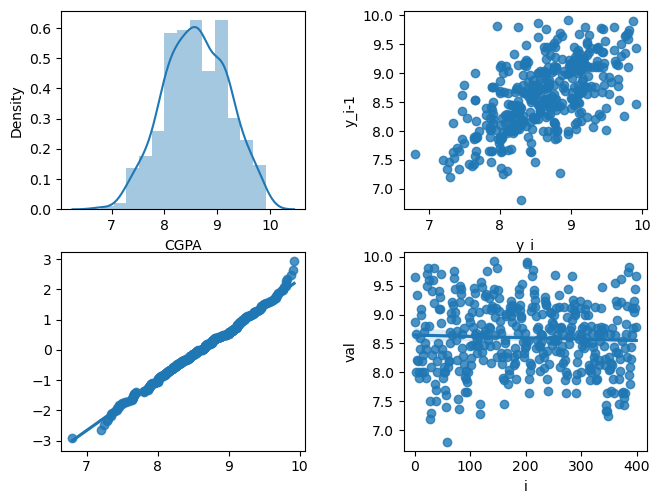

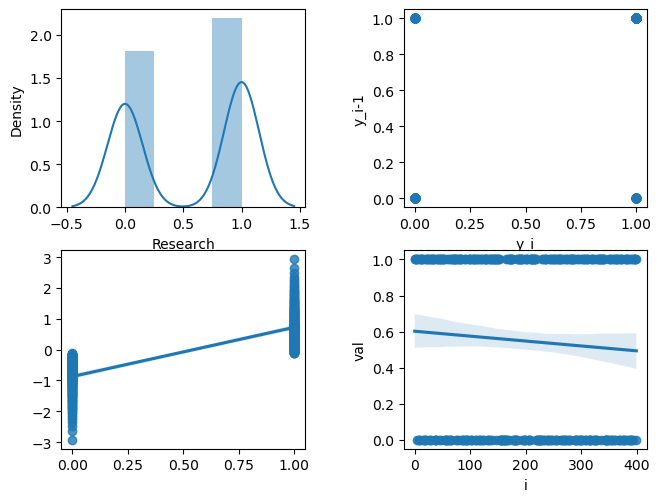

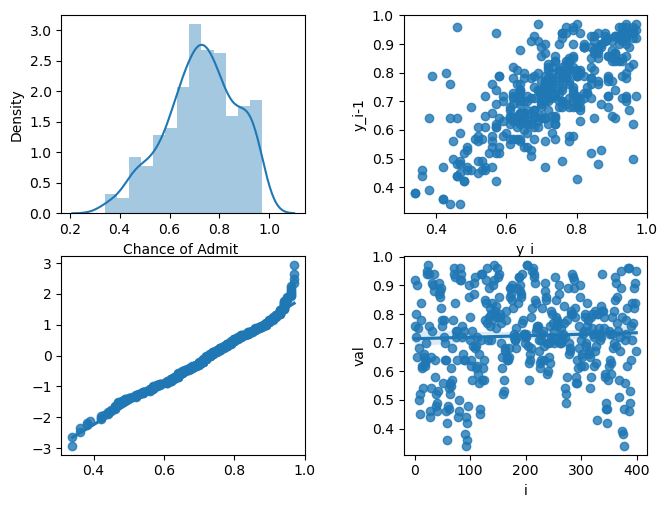

In [430]:
for column in admit.columns:
    multiplePlots(admit[column])

Within the dataset, there are 8 different variables with numeric values associated with them. GRE scores average around 316 out of 340, forming a normal distribution bell curve with a standard deviation of 11.4. TOEFL scores share a similar distribution shape, with a median of 107 out of 120 and a standard deviation of 6 points. University rating is on a 1-5 scale, with most values falling around 3. Statements of Purpose and Letter of Recommendations are also scored out of 5, with most values falling around 3 to 4. Undergraduate GPA is scored differently than our own GPA scale at Michigan, with scores out of 10 averaging around 8.6 and following a normal distribution. Research is binary, with values of either 0 or 1, but an average of .54 indicates that more students do research than not. All of these variables compute into the chance of admission, which has an average around 72% and a maximum value within the dataset of 97%. It is interesting that no person in the dataset has a 100% chance of admit, which likely has to do with the fact that no person in the dataset has perfect scores on all of these variables.

## Task 2a (4 points):
Use scikit-learn to conduct a linear regression that models the chance of admission based on the other variables.  Be sure to exclude "Serial No." as an explanatory variable.  Be sure to pre-process the data appropriately.  Assess how good your model is by reporting the root mean squared error (RMSE) using the test dataset from an 80-20 train-test-split of the original dataset.

<AxesSubplot:>

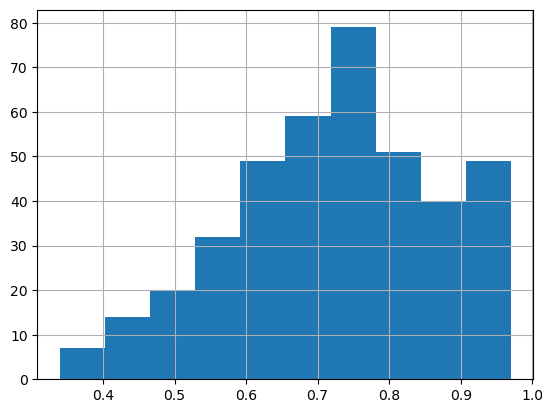

In [431]:
admit['Chance of Admit '].hist()

In [432]:
admit["admit_cat"] = pd.cut(admit["Chance of Admit "],
                            bins=[0., 0.5, 0.625, .765, .875, np.inf],
                            labels=[1, 2, 3, 4, 5])

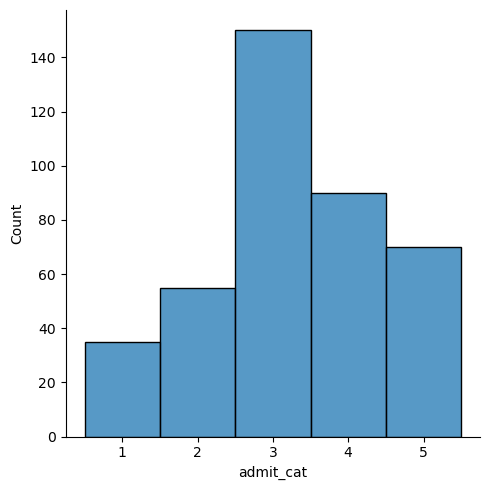

In [433]:
sns.displot(admit["admit_cat"])

In [434]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(admit, admit["admit_cat"]):
    strat_train_set = admit.iloc[train_index]
    strat_test_set = admit.iloc[test_index]

In [435]:
strat_test_set["admit_cat"].value_counts() / len(strat_test_set)

3    0.3750
4    0.2250
5    0.1750
2    0.1375
1    0.0875
Name: admit_cat, dtype: float64

In [436]:
admit["admit_cat"].value_counts() / len(admit)

3    0.3750
4    0.2250
5    0.1750
2    0.1375
1    0.0875
Name: admit_cat, dtype: float64

In [437]:
def income_cat_proportions(data):
    return data["admit_cat"].value_counts() / len(data)


train_set, test_set = train_test_split(admit, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(admit),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = (100 * compare_props["Random"] /
                                 compare_props["Overall"] - 100)
compare_props["Strat. %error"] = (100 * compare_props["Stratified"] /
                                  compare_props["Overall"] - 100)

In [438]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.0875,0.0875,0.125,42.857143,0.0
2,0.1375,0.1375,0.125,-9.090909,0.0
3,0.3750,0.3750,0.350,-6.666667,0.0
4,0.2250,0.2250,0.175,-22.222222,0.0
5,0.1750,0.1750,0.225,28.571429,0.0


In [439]:
for set_ in (admit, strat_train_set, strat_test_set):
    set_.drop("admit_cat", axis=1, inplace=True)

In [440]:
train_y = strat_train_set['Chance of Admit '].copy()
train_X = strat_train_set.drop('Chance of Admit ', axis=1)

In [441]:
train_X

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
Serial No.,,,,,,,
334,319,108,3,3.0,3.5,8.54,1
248,311,104,2,2.5,3.5,8.48,0
349,302,99,1,2.0,2.0,7.25,0
135,333,113,5,4.0,4.0,9.28,1
150,311,106,2,3.5,3.0,8.26,1
...,...,...,...,...,...,...,...
92,299,97,3,5.0,3.5,7.66,0
328,295,101,2,2.5,2.0,7.86,0
379,303,98,1,2.0,2.5,7.65,0


In [442]:
train_prepared = StandardScaler().fit_transform(train_X)

In [443]:
lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_y)

LinearRegression()

In [444]:
lin_reg.score(train_prepared, train_y)

0.7932317877149252

In [445]:
lin_reg.predict(train_prepared[:5])

array([0.73719252, 0.67332116, 0.45648578, 0.88106254, 0.66822109])

In [446]:
X_test = strat_test_set.drop('Chance of Admit ', axis=1)
y_test = strat_test_set['Chance of Admit '].copy()

X_test_prepared = StandardScaler().fit_transform(X_test)

final_predictions = lin_reg.predict(X_test_prepared)

lin_mse = mean_squared_error(y_test, final_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.054533574747801884

Our root mean square error (RMSE) of 0.0545 is the how far off on average we are going to be from the true values of our dataset. It tells us how concentrated our data is around the line of best fit. This means that our model fits well and has good predictions when a linear regression is conducted, since 5.5% is a relatively small deviation for error in the chance of admission.

## Task 2b (1 point):
Based on your work in the previous task, what is the probability of admission for someone with a GRE score or 325, a TOEFL score of 108, a university rating of 3, an statement of purpose score of 3.0, a letter of recommendation score of 3.5, a high-school grade point average of 8.9, and who has research experience.

In [447]:
someone = [325, 108, 3, 3.0, 3.5, 8.9, 1]
someone = pd.DataFrame(np.array(someone).reshape(1, -1),
                       columns=['GRE Score', 'TOEFL Score',
                                'University Rating', 'SOP',
                                'LOR ', 'CGPA', 'Research'])
someone

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
0,325.0,108.0,3.0,3.0,3.5,8.9,1.0


In [449]:
someone_prepared = StandardScaler().fit_transform(someone)
lin_reg.predict(someone_prepared)

array([0.723])

After scaling the data similarly to our train dataset, the linear regression model predicts that this person will have a 72.3% probability of admission after considering the various scores and credentials that this candidate possesses.

## Task 3 (1 points):
Decide on a reasonable value for a threshold for admission.  Pick a value that you would feel comfortable with if you wanted to know whether you were likely to be accepted into a graduate program.  Create a new variable called "admitted" that is set to 1 if the chance of admission value is equal to or greater than your chosen threshold, 0 otherwise.

In [393]:
admit_percentile = np.quantile(final_predictions, .75)
admit_percentile

0.8258560285117846

In [394]:
admit['admitted'] = np.where(admit['Chance of Admit '] >= admit_percentile,
                             1, 0)

In [395]:
admit

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,admitted
Serial No.,,,,,,,,,
1,337,118,4,4.5,4.5,9.65,1,0.92,1
2,324,107,4,4.0,4.5,8.87,1,0.76,0
3,316,104,3,3.0,3.5,8.00,1,0.72,0
4,322,110,3,3.5,2.5,8.67,1,0.80,0
5,314,103,2,2.0,3.0,8.21,0,0.65,0
...,...,...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1,0.82,0
397,325,107,3,3.0,3.5,9.11,1,0.84,1
398,330,116,4,5.0,4.5,9.45,1,0.91,1


After a quick search, I found that the acceptance rate for the University of Michigan in my year of admission was around 25%. So, I decided to make this the value that I would be comfortable with to know whether I was likely to be accepted into a graduate program. The 75th percentile, or the top 25% of applicants, is what I am setting this value at. For the chances of admit within the dataset, this includes values above ~0.8259. 

## Task 4 (5 points):
Using your **test** dataset (i.e. approximately 80 rows) from above, conduct an agglomerative clustering analysis using average linkage based on PCA projections of the original data onto 2 dimensions (remember to scale your data before doing the PCA).  Report the percentage of variance retained in the first two principal components. 

Do not use the chance of admission column or the "admitted" variable you created in the previous step in your input data.

Create a dendrogram, pick an appropriate "cut line" and comment on the composition of each of the resulting clusters.  Comment on the degree to which the clusters correspond to admission probabilities (note: you may find it helpful to examine the values of "admitted").

In [396]:
pipe = Pipeline([
    ('fillna', SimpleImputer(strategy='constant', fill_value=1)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42)),
    ('agglomerative', AgglomerativeClustering(affinity='euclidean',
                                              linkage='average', n_clusters=2))
])

In [397]:
model = pipe.fit_predict(X_test)
model

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [398]:
np.bincount(model)

array([57, 23], dtype=int64)

In [399]:
pipe.named_steps.pca.explained_variance_ratio_

array([0.73119573, 0.09750423])

In [400]:
sum(pipe.named_steps.pca.explained_variance_ratio_)

0.8286999607610288

The percentage of variance retained within the first two principle components is .8287 (82.87%), with .7312 (73.12%) in the first and .0975 (9.75%) in the second. 

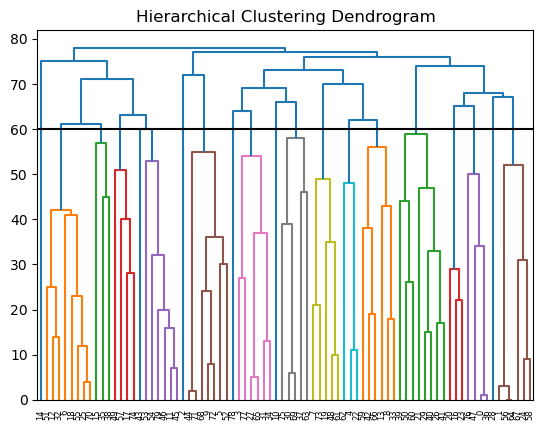

In [401]:
def plot_dendrogram(model, **kwargs):
    children = model.children_
    distance = np.arange(children.shape[0])
    n = distance + 2
    children_distance_n = [children, distance, n]
    linkage_matrix_int = np.column_stack(children_distance_n)
    linkage_matrix = linkage_matrix_int.astype(float)
    dendrogram(linkage_matrix, **kwargs)
    color_threshold = kwargs.pop('color_threshold', None)
    plt.axhline(y=color_threshold, c='k')


plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(pipe.named_steps.agglomerative,
                color_threshold=60
                )
plt.xticks(rotation=90)
plt.show()

At the given cut line at 60, there are 20 clusters remaining of the 80 original clusters. Within the test dataset, this represents 80 different applicants of the ones in the dataset, and these are consolidated into the 20 at this cut line. Within the 'admitted' values, there are 25% of the original dataset values, which is similar to the number of clusters remaining within this dendrogram. In the agglomerative clustering model completed prior to this dendrogram, there are 23 members of 1 and 57 in 0, similar to the cutoff of 60 on this diagram. These clusters represent graduate school applicants that are put together based on similar qualities in their application variables. 

## Task 5 (4 points):
Conduct a k-means clustering of the admissions data.  Pre-process the data using a 2-dimensional PCA (remember to scale your data before doing the PCA).  Again, do not use the chance of admission or the "admitted" variable you created earlier.  Use the average silhouette score to determine the optimal number of clusters and show the silhouette plot for the optimal number of clusters.

In [402]:
admit_y = admit['Chance of Admit ']
admit_X = admit.drop(['Chance of Admit ', 'admitted'], axis=1).copy()

In [403]:
pipe0 = Pipeline([
    ('fillna', SimpleImputer(strategy='constant', fill_value=1)),
    ('scale', StandardScaler()),
    ('pca', PCA(n_components=2, random_state=42)),
])

In [404]:
pipe1 = Pipeline([
    ('preprocessing', pipe0),
    ('kmeans', KMeans(n_clusters=2, init='k-means++', random_state=42)),
])

In [405]:
Xvalues = admit_X.values

In [406]:
Xformed = pipe0.fit_transform(Xvalues)

For n_clusters = 2 The average silhouette_score is : 0.49259872351143114
For n_clusters = 3 The average silhouette_score is : 0.41735177862251827
For n_clusters = 4 The average silhouette_score is : 0.4343346421404948
For n_clusters = 5 The average silhouette_score is : 0.4315225179273028
For n_clusters = 6 The average silhouette_score is : 0.42854123262307153


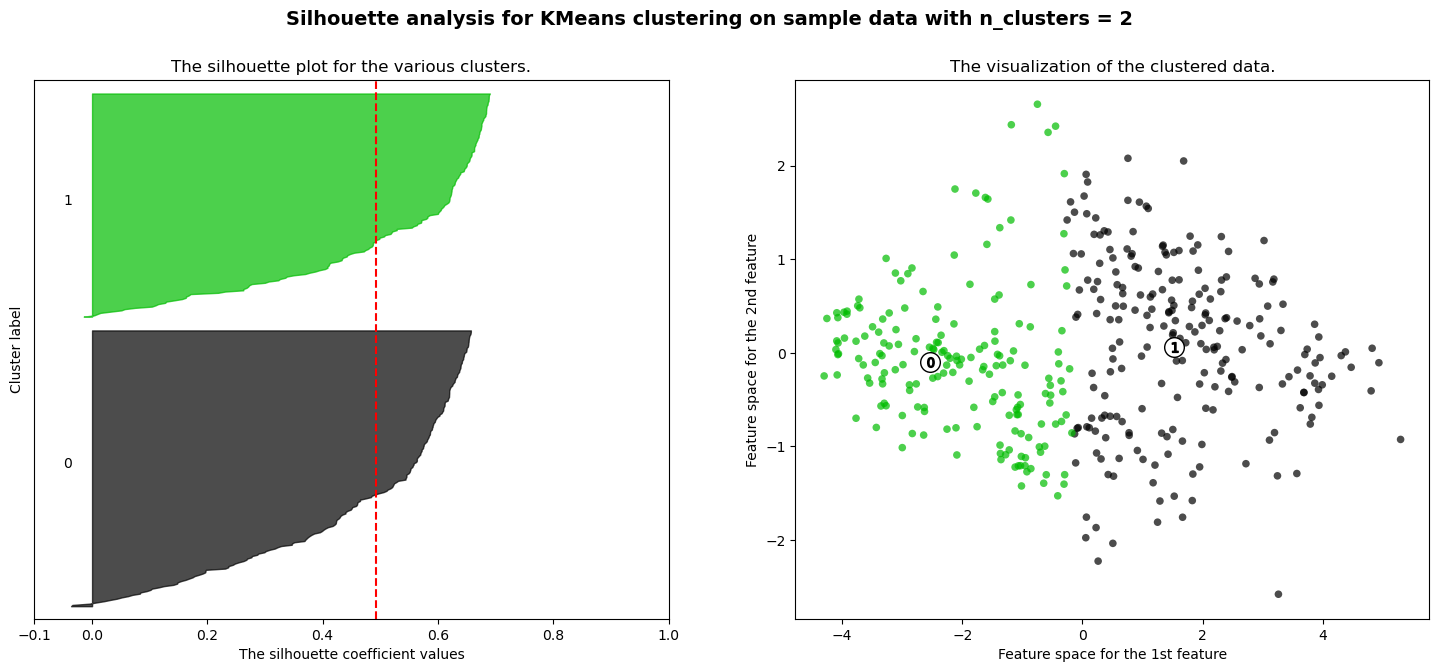

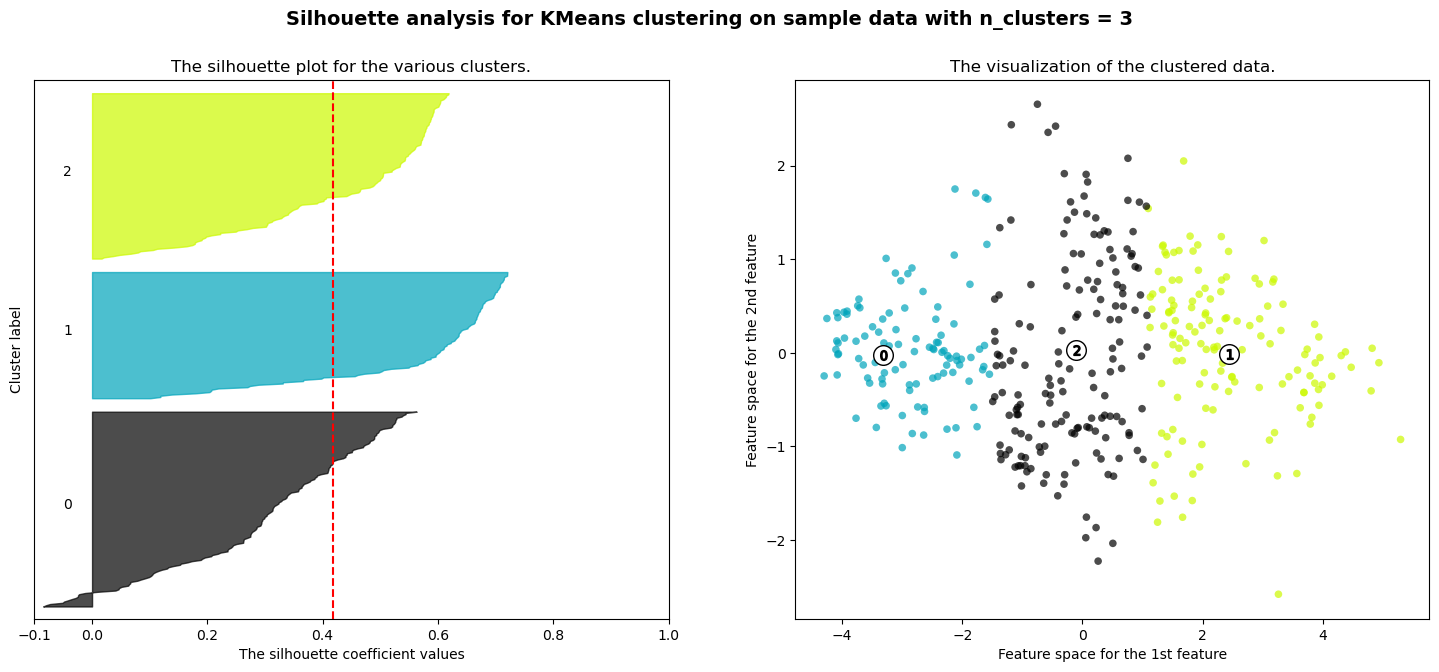

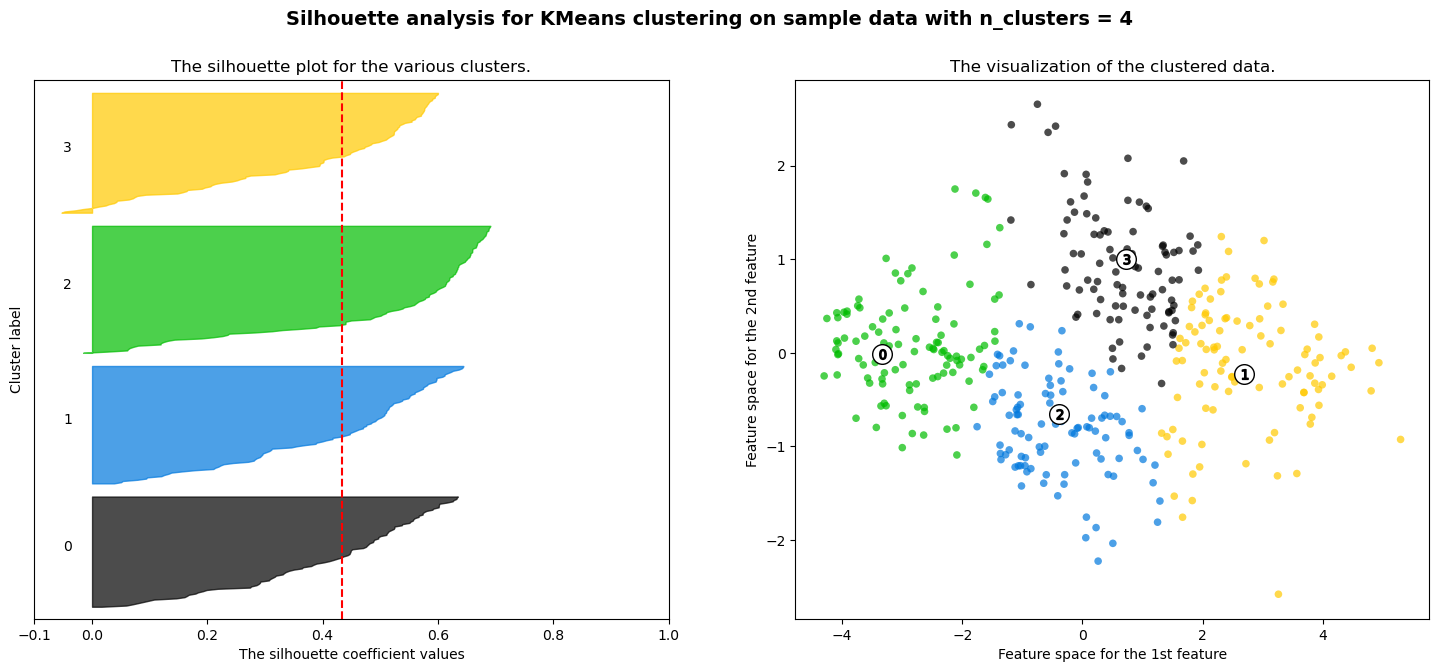

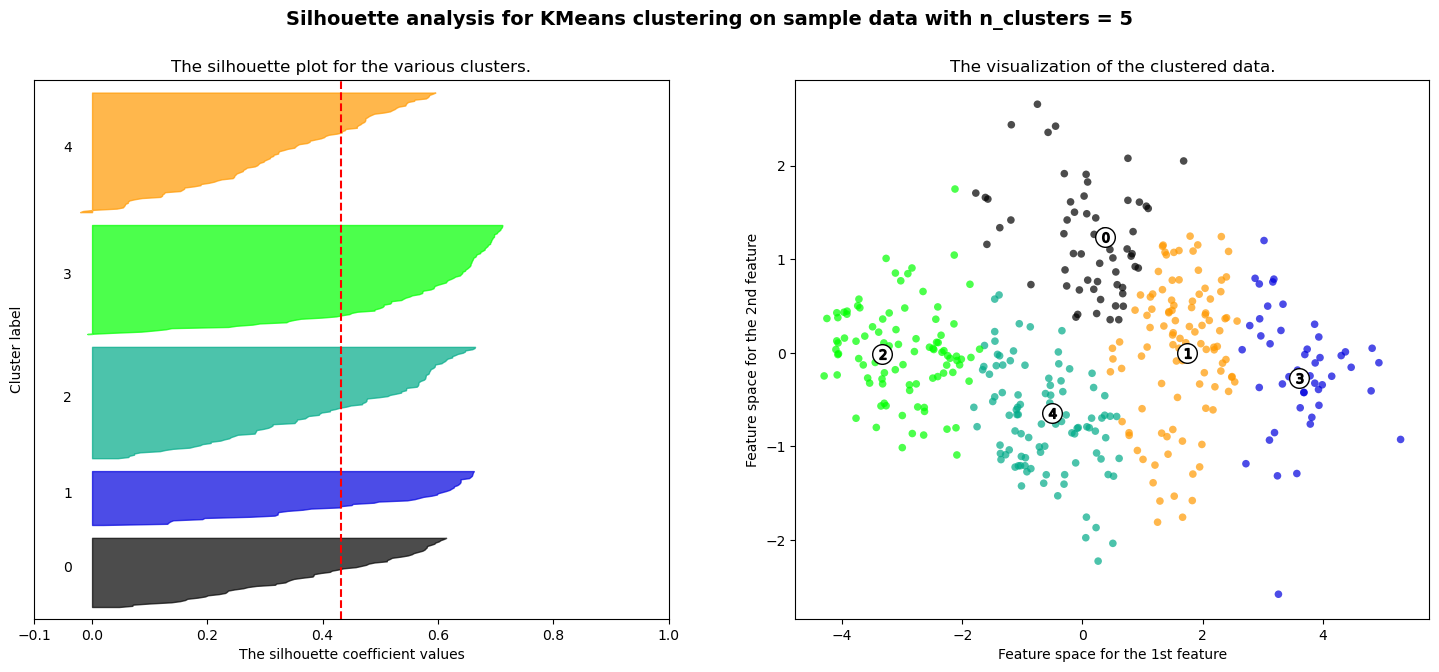

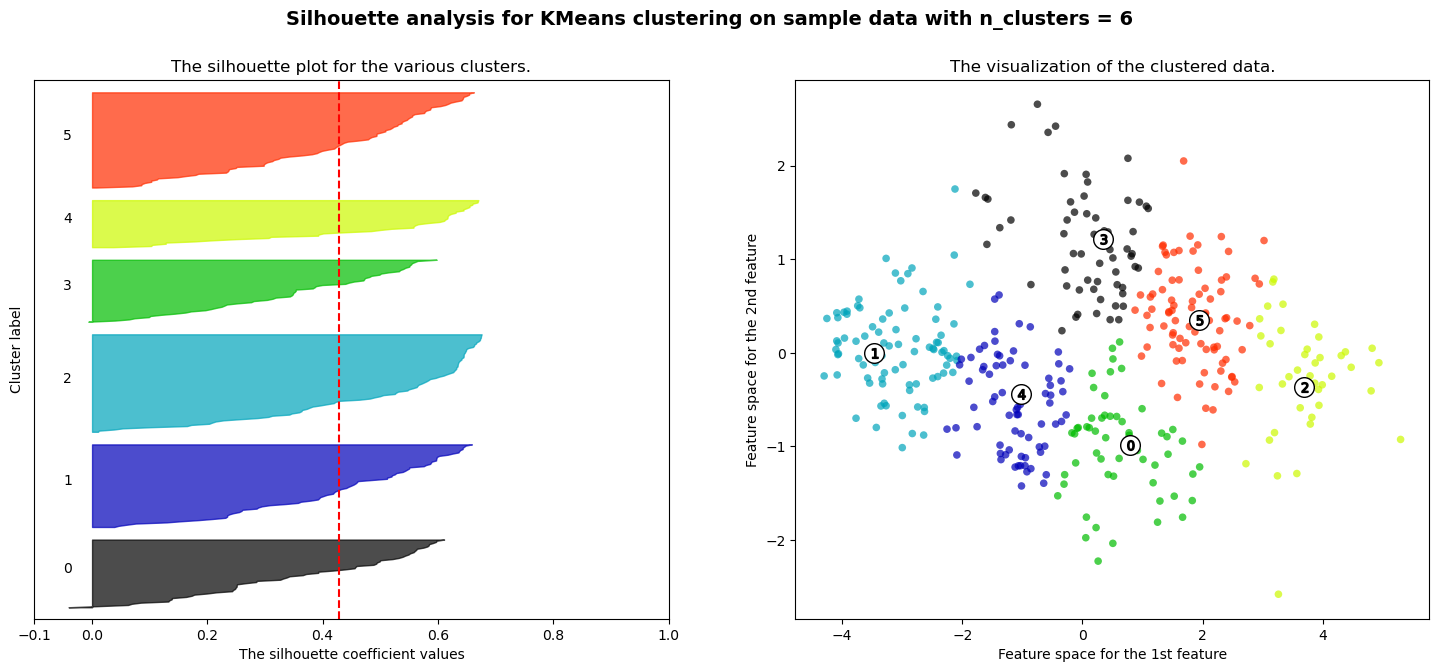

In [407]:
range_n_clusters = [2, 3, 4, 5, 6]
label_points = False
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(Xformed) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 42 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    #cluster_labels = clusterer.fit_predict(Xformed)

    pipe1.named_steps.kmeans.set_params(n_clusters=n_clusters,random_state=42)
    clusterer = pipe1.named_steps.kmeans
    cluster_labels = pipe1.fit_predict(X)
    cluster_labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(Xformed)
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(Xformed, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(Xformed, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(Xformed[:, 0], Xformed[:, 1], marker='o', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    if label_points:
        for i,v in enumerate(Xformed):
            ax2.text(v[0],v[1],y.iloc[i][0],alpha=0.4)


    # Labeling the clusters
    centers = clusterer.cluster_centers_
    #print(centers)
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
plt.show()

The optimal number of clusters, chosen on the basis of silhouette score, is 2 clusters. This has the highest average silhouette score of 0.4925, compared to the other silhouette analyses and visualizations created. Based on the average silhouette score market by the dashed red line, we can see that a larger percentage of values are above this line, rather than below it. This measn that these points are reasonably close to the centroid.

## Task 6 (3 points):
Show the results of a t-SNE analysis of the admissions data.  As before, do not use the chance of admission column or the "admitted" variable you created in the previous step in your input data.  Color the points in your visualization based on the "admitted" variable you created earlier.

In [413]:
tsne = TSNE(n_components=2,
            random_state=42)
tsne_X = admit_X.copy()
y = admit.index
X_2d = tsne.fit_transform(tsne_X)

In [414]:
tsne_X

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research
Serial No.,,,,,,,
1,337,118,4,4.5,4.5,9.65,1
2,324,107,4,4.0,4.5,8.87,1
3,316,104,3,3.0,3.5,8.00,1
4,322,110,3,3.5,2.5,8.67,1
5,314,103,2,2.0,3.0,8.21,0
...,...,...,...,...,...,...,...
396,324,110,3,3.5,3.5,9.04,1
397,325,107,3,3.0,3.5,9.11,1
398,330,116,4,5.0,4.5,9.45,1


In [415]:
tsne_labelled = pd.DataFrame(X_2d, columns=['d1', 'd2'])
tsne_labelled

,d1,d2
0,36.234371,-2.929241
1,9.269361,-6.290213
2,-3.921547,-6.001669
3,8.763801,-2.271850
4,-11.315769,5.878796
...,...,...
395,13.107040,-3.529269
396,9.726066,-7.179156
397,28.693716,-4.976294
398,-13.427836,3.387304


<AxesSubplot:xlabel='d1', ylabel='d2'>

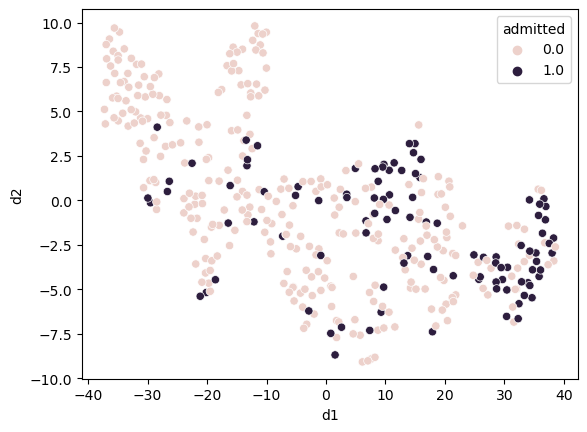

In [418]:
sns.scatterplot(data=tsne_labelled, x='d1', y='d2', hue=admit['admitted'])

From this t-SNE analysis of the admissions data, we can see that clusters of those deemed admittable are compiled in two groups on the scatterplot, with other admittable candidates spread out in smaller groups throughout the diagram. A larger proportion of non-admittable candidates are seen throughout the t-SNE visualization in larger groups. This shows that the admitted have more in common with each other for the most part, while non-admitted applicants are spread out in larger groups with other non-admitted. This means that those who were not considered admitted have things in common with each other, but in different regards, so they are spread out in different areas of the diagram.